# ARIMA / SARIMA алгоритмы для сезонных timescale данных

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

## Загрузка данных

In [2]:
df = pd.read_csv("./milk-production.csv")

df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns={"Monthly milk production (pounds per cow)": "milk_production"})

df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df["Month"] = df["Month"].dt.strftime("%Y-%m")
df = df.set_index("Month")

print(df.head(), end="\n\n")
df.info()

         milk_production
Month                   
1962-01              589
1962-02              561
1962-03              640
1962-04              656
1962-05              727

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01 to 1975-12
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   milk_production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6+ KB


## Разведочный анализ данных

In [3]:
# Статистическое описание данных
print(df.describe())

       milk_production
count       168.000000
mean        754.708333
std         102.204524
min         553.000000
25%         677.750000
50%         761.000000
75%         824.500000
max         969.000000


In [4]:
# Проверка пропущенных значений
print(df.isnull().sum())

milk_production    0
dtype: int64


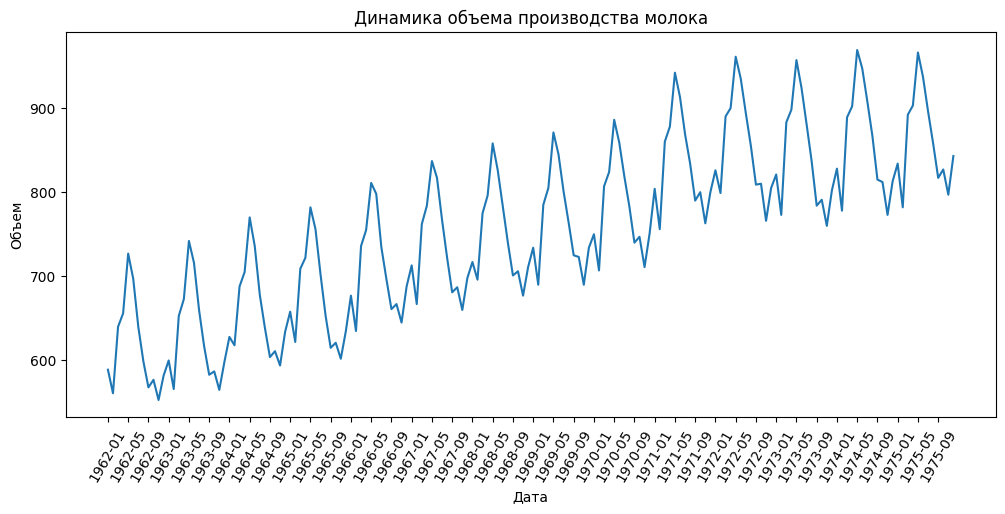

In [5]:
# Визуализация временного ряда
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["milk_production"])
plt.xlabel("Дата")
plt.ylabel("Объем")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.title("Динамика объема производства молока")
plt.show()

- Данные идут непрерывно с начала 1962 года по конец 1975 года
- Видим общий тренд к росту: с 600 до 900
- Заметны регулярные колебания в течение каждого года

##  Анализ временного ряда

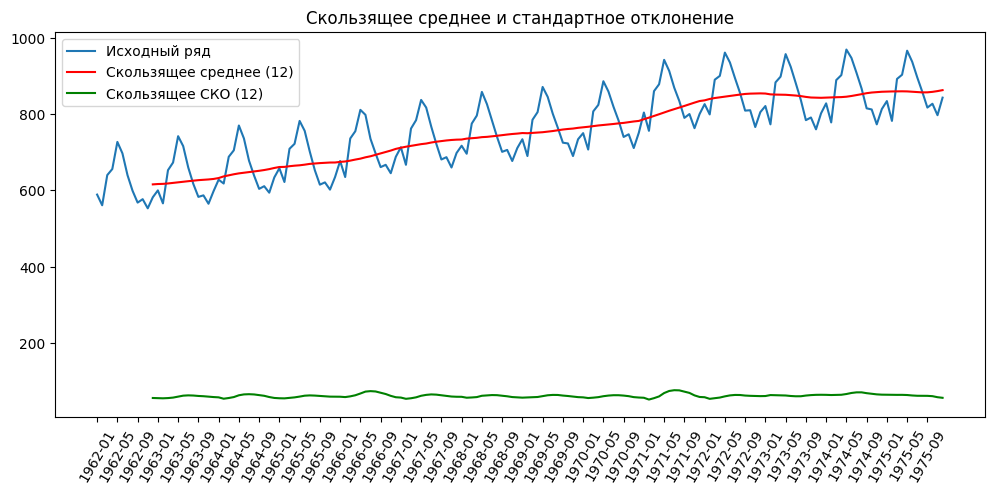

In [6]:
# Скользящее среднее и скользящее стандартное отклонение
rolling_mean = df["milk_production"].rolling(window=12).mean()
rolling_std = df["milk_production"].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(df["milk_production"], label="Исходный ряд")
plt.plot(rolling_mean, color="red", label="Скользящее среднее (12)")
plt.plot(rolling_std, color="green", label="Скользящее СКО (12)")
plt.title("Скользящее среднее и стандартное отклонение")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.legend()
plt.show()

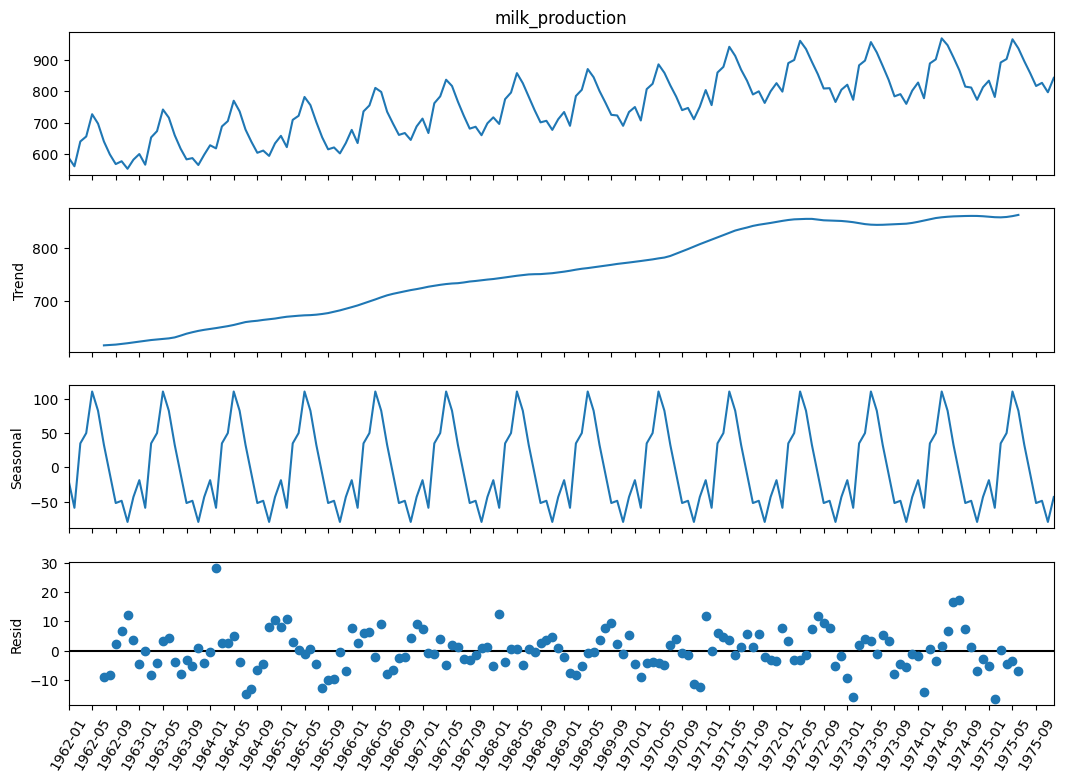

In [7]:
# Сезонная декомпозиция
decomposition = seasonal_decompose(df["milk_production"], period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.show()

- Чётко виден тренд на увеличение производства
- Сезонность повторяется по годам
- Остатки не имеют выраженной зависимости от времени

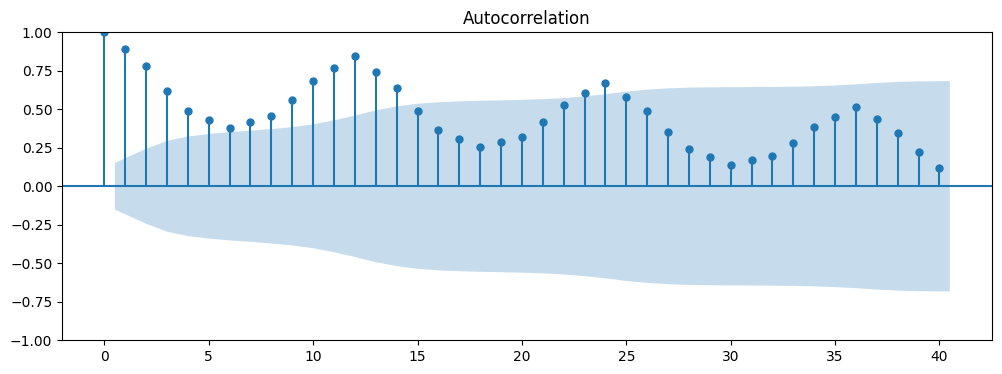

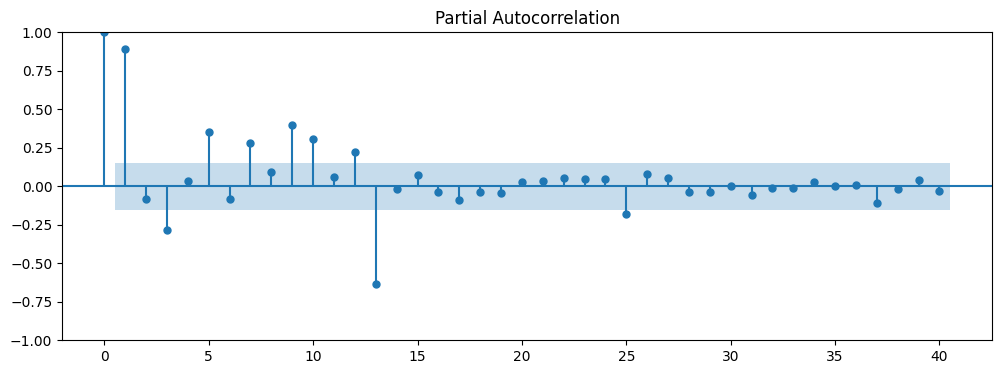

In [8]:
# Автокорреляция
plt.figure(figsize=(12, 4))
plot_acf(df["milk_production"], lags=40, ax=plt.gca())
plt.show()

# Частичная автокорреляция
plt.figure(figsize=(12, 4))
plot_pacf(df["milk_production"], lags=40, ax=plt.gca())
plt.show()

- ACF показывает медленное затухание, что свидетельствует о наличии выраженного тренда и сезонности
- Присутствуют заметные пики на лагах, кратных 12, что говорит о сезонности (12 месяцев)

## Тест на стационарность ряда

In [9]:
result = adfuller(df["milk_production"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical Values:")
    print(f"   {key}, {value}")

ADF Statistic: -1.303812
p-value: 0.627427
Critical Values:
   1%, -3.473542528196209
Critical Values:
   5%, -2.880497674144038
Critical Values:
   10%, -2.576878053634677


- p-value значительно больше 0.05, ряд нестационарен

## Разделение данных на тестовую и тренировочную выборку

In [10]:
test_ratio = 0.2

train = df.iloc[: -int(len(df) * test_ratio)]
test = df.iloc[-int(len(df) * test_ratio) :]

print("Размер train:", train.shape)
print("Размер test:", test.shape)

Размер train: (135, 1)
Размер test: (33, 1)


## Автоматический подбор параметров

In [11]:
auto_arima_results = auto_arima(
    train["milk_production"],
    start_p=0,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    d=1,  # Дифференциация
    seasonal=True,  # Включаем поиск SARIMA
    m=12,  # Сезонный период = 12
    start_P=0,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    D=1,  # Сезонная дифференциация
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(auto_arima_results.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=896.686, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=864.071, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=851.484, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=885.000, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=853.404, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=853.377, Time=0.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=864.322, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=860.523, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=853.224, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=852.958, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=851.800, Time=0.07 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=854.843, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=853.416, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]

- Параметры лучшей модели ARIMA: p=0, d=1, q=1
- Параметры лучшей модели SARIMA: p=0, d=1, q=1, P=0, D=1, Q=1, m=12

## Построение и обучение модели ARIMA

c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        milk_production   No. Observations:                  135
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -700.116
Date:                Sun, 30 Mar 2025   AIC                           1404.232
Time:                        19:20:06   BIC                           1410.028
Sample:                    01-01-1962   HQIC                          1406.588
                         - 03-01-1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0231      0.127      0.182      0.856      -0.226       0.272
sigma2      2021.5462    351.498      5.751      0.000    1332.623    2710.469
Ljung-Box (L1) (Q):                   0.00   Jarque-

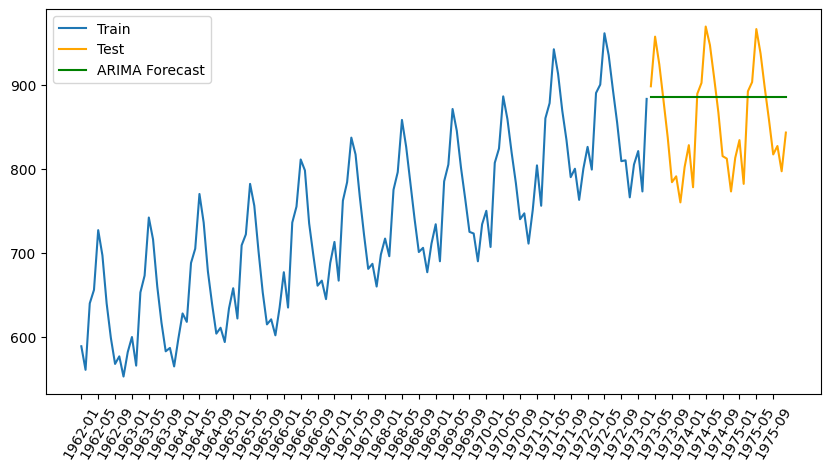

RMSE ARIMA: 66.90291078057884


In [12]:
model_arima = ARIMA(train["milk_production"], order=(0, 1, 1))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

# Прогноз
forecast_arima = model_arima_fit.forecast(steps=len(test))
forecast_arima.index = test.index

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(train["milk_production"], label="Train")
plt.plot(test["milk_production"], label="Test", color="orange")
plt.plot(forecast_arima, label="ARIMA Forecast", color="green")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.legend()
plt.show()

# Оценка
rmse_arima = np.sqrt(mean_squared_error(test["milk_production"], forecast_arima))
print("RMSE ARIMA:", rmse_arima)

- Полученная модель имеет невысокую точность предсказания

## Построение и обучение модели SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                    milk_production   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -422.742
Date:                            Sun, 30 Mar 2025   AIC                            851.484
Time:                                    19:20:06   BIC                            859.896
Sample:                                01-01-1962   HQIC                           854.901
                                     - 03-01-1973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2947      0.086     -3.416      0.001      -0.464      -0.126
ma.S.L12      -0.6210      0.090   

c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


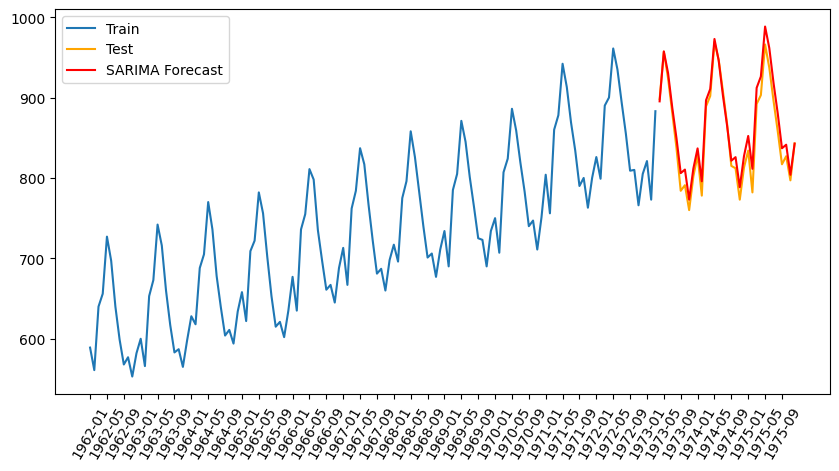

RMSE SARIMA: 15.054319851617384


In [13]:
model_sarima = SARIMAX(
    train["milk_production"], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)
)
model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

# Прогноз
forecast_sarima = model_sarima_fit.forecast(steps=len(test))
forecast_sarima.index = test.index

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(train["milk_production"], label="Train")
plt.plot(test["milk_production"], label="Test", color="orange")
plt.plot(forecast_sarima, label="SARIMA Forecast", color="red")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.legend()
plt.show()

# Оценка
rmse_sarima = np.sqrt(mean_squared_error(test["milk_production"], forecast_sarima))
print("RMSE SARIMA:", rmse_sarima)

- Можно видеть, что модель SARIMA показывает результаты намного лучше, чем ARIMA, поскольку способна учитывать сезонные компоненты

## Графики прогноза по моделям

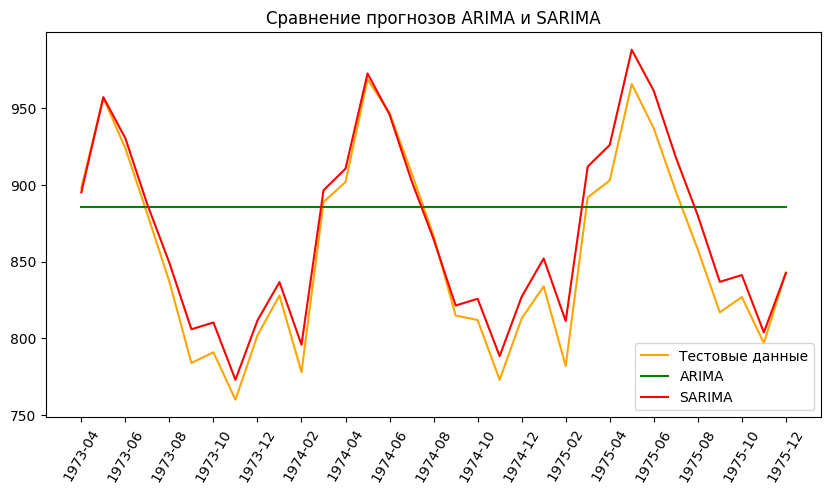

RMSE ARIMA: 66.90291078057884
RMSE SARIMA: 15.054319851617384


In [14]:
plt.figure(figsize=(10, 5))
plt.plot(test["milk_production"], label="Тестовые данные", color="orange")
plt.plot(forecast_arima, label="ARIMA", color="green")
plt.plot(forecast_sarima, label="SARIMA", color="red")
plt.title("Сравнение прогнозов ARIMA и SARIMA")
plt.xticks(
    test.index[::2],
    rotation=60,
)
plt.legend()
plt.show()

print("RMSE ARIMA:", rmse_arima)
print("RMSE SARIMA:", rmse_sarima)

- По визуальному сравнению кривых прогноза видно, что SARIMA имеет точность намного выше, а также улавливает сезонные пики и спады